#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score, GridSearchCV

In [2]:
data = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
def data_info(df):
        display(df)# просмотр первых и последних строк датасета
        df.info() # общий анализ данных
        print("Пропусков в данных: ")
        print(df.isna().sum().sum(), end='\n'*2)
        print()
        print("Данные монотонные, а значит в хронологическом порядке -", data.index.is_monotonic) 
        return

In [4]:
data_info(data)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
Пропусков в данных: 
0


Данные монотонные, а значит в хронологическом порядке - True


Перед нами данные о количестве заказов фирмы "Чётенькое такси" с 1 марта 2018года до 31 августа 2018 года, разбитые по 10 минут, индексы монотонные - тоесть данные находятся в хронологическом порядке

Выполню ресемплирование по одному часу.

In [5]:
data.sort_index(inplace=True)
data_resample = data.resample('1H').sum()

In [6]:
data_resample

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


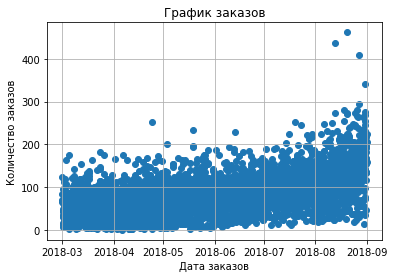

In [7]:
plt.scatter(data_resample.index.values,
           data_resample['num_orders'])
plt.title('График заказов')
plt.xlabel('Дата заказов')
plt.ylabel('Количество заказов')
plt.grid(True)
plt.show()

График рассеивания дает понять, что за весь период ежемесячно количество заказов в среднем на отметке 0-100 шт, но начиная с середины июля график смещается от нуля вверх, а значит минимальное количество заказов увеличивается

На данном этапе я познакомился с данными и сгруппировал их с интервалом в 1час, вместо 10 минут, все данные находятся в хронологическом порядке. Теперь нужно проанализировать данные

## Анализ

Проверка данных на стационарность

In [8]:
decomposed = seasonal_decompose(data_resample['num_orders'])

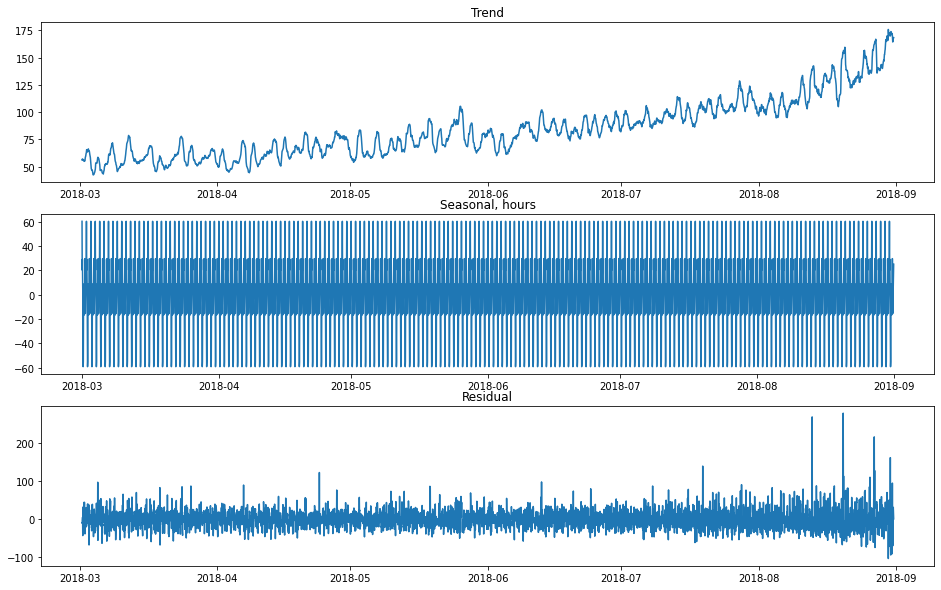

In [9]:
fig, axs = plt.subplots(3, figsize=(16,10), sharex=False)
axs[0].plot(decomposed.trend)
axs[0].set_title("Trend")

axs[1].plot(decomposed.seasonal)
axs[1].set_title("Seasonal, hours")

axs[2].plot(decomposed.resid)
axs[2].set_title("Residual")

plt.show()

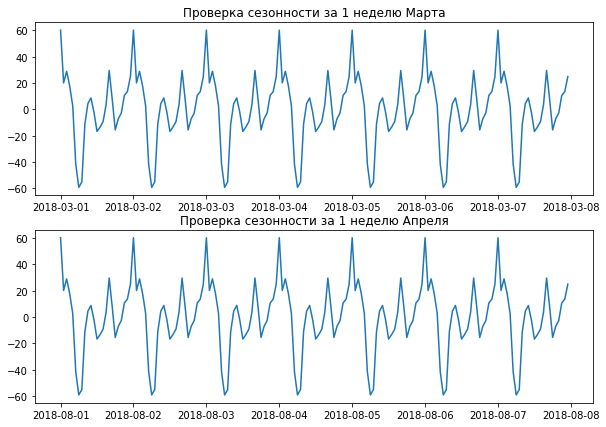

In [10]:
fig, axs = plt.subplots(2, figsize=(10,7), sharex=False)
axs[0].plot(decomposed.seasonal['2018-03-01': '2018-03-07'])
axs[0].set_title("Проверка сезонности за 1 неделю Марта")

axs[1].plot(decomposed.seasonal['2018-08-01': '2018-08-07'])
axs[1].set_title("Проверка сезонности за 1 неделю Апреля")
plt.show()


    В данных присутствует сезонность, которая не зависит от времени
    
    Так же так как показатель Trend'a с июня к сентябрю возрастает - значит возрастает среднее значение, тоесть данные не стационарны

Вычислим разность временного ряда, что бы сделать данные стационарными

In [11]:
data_resample_copy = data_resample.copy()
data_resample_copy.shift()

,num_orders
datetime,
2018-03-01 00:00:00,NaN
2018-03-01 01:00:00,124.0
2018-03-01 02:00:00,85.0
2018-03-01 03:00:00,71.0
2018-03-01 04:00:00,66.0
...,...
2018-08-31 19:00:00,207.0
2018-08-31 20:00:00,136.0
2018-08-31 21:00:00,154.0


Text(0, 0.5, 'Количество заказов')

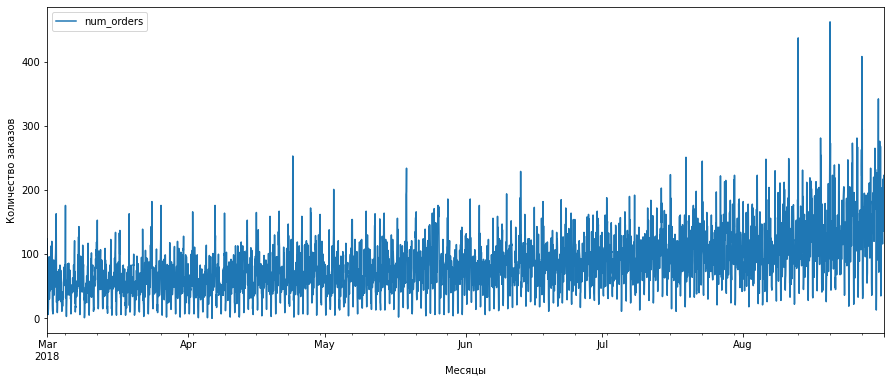

In [12]:
ax = data_resample.plot(figsize=(15, 6));
ax.set_xlabel("Месяцы")
ax.set_ylabel("Количество заказов")

Мы имеем дело с нестационарным рядом

## Обучение

Для обучения моделей создадим признаки

In [13]:
# Создание функции для признаков
def make_features(df, max_lag, rolling_mean_size):
    df_copy=df.copy()
    
    # Формирование календарных признаков
    df_copy['dayofweek'] = df_copy.index.dayofweek
    df_copy['hour'] = df_copy.index.hour
    
    # Формирование отстающих признаков
    for lag in range(1, max_lag + 1):
        df_copy['lag_{}'.format(lag)] = df_copy['num_orders'].shift(lag)
        
    # Добавление признака скользящего среднего
    df_copy['rolling_mean'] = df_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    return df_copy

Вызовем функцию max_features() с max_lag = 8 и rolling_mean_size = 8

In [14]:
date_features = make_features(data_resample,24,24)

Разбиение данных на выборки(согласно условиям тестовая выборка должна содержать 10%)

In [15]:
train_valid, test = train_test_split(date_features, shuffle=False, test_size=0.1)
train_valid = train_valid.dropna()

In [16]:
display(train_valid.shape)
display(test.shape)

(3950, 28)

(442, 28)

In [17]:
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)

In [18]:
display(train.shape)
display(valid.shape)

(3555, 28)

(395, 28)

Разобьем выборки на признаки и целевой признак

In [19]:
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_valid = valid.drop(['num_orders'], axis=1)
target_valid = valid['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Подбор модели и гиперпараметров

In [20]:
best_rmse = []

    Для оценки метрики я буду использовать 3 модели:
    
        Линейная регрессия
        LightGBT
        Catboost

#### Линейная регрессия

In [21]:
target_train.shape

(3555,)

In [22]:
%%time
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
prediсt = model_lr.predict(features_valid)
rmse_lr = mean_squared_error(target_valid, prediсt) ** 0.5

display("RMSE Линейной регресии ", rmse_lr)

'RMSE Линейной регресии '

34.32543978656721

CPU times: user 73.7 ms, sys: 150 ms, total: 224 ms
Wall time: 184 ms


In [23]:
best_rmse.append(rmse_lr)

#### LightGBT

In [44]:
%%time

param_grid = {'max_depth': range(2, 11, 2)}
            
               
lgb_model = lgb.LGBMRegressor()
tscv = TimeSeriesSplit(n_splits=3)

search_lgb = GridSearchCV(lgb_model, param_grid, cv=tscv, scoring='neg_root_mean_squared_error')
search_lgb.fit(features_train, target_train)

CPU times: user 40min 9s, sys: 30.3 s, total: 40min 39s
Wall time: 41min 1s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LGBMRegressor(),
             param_grid={'max_depth': range(2, 11, 2)},
             scoring='neg_root_mean_squared_error')

In [45]:
rmse_lgb = -search_lgb.best_score_
print('Лучшее значение RMSE для LGBMRegressor: {}'
      '\n при значениях гиперпараметров: {}'.format(-search_lgb.best_score_,search_lgb.best_params_))

Лучшее значение RMSE для LGBMRegressor: 24.628602121137977
 при значениях гиперпараметров: {'max_depth': 4}


In [46]:
best_rmse.append(rmse_lgb)

#### Catboost

In [27]:
%%time

catboost = CatBoostRegressor(loss_function='RMSE',verbose=100)
parameters_cat = {'depth':[1,10], 'learning_rate':np.arange(0.1,0.5,0.2)}
tscv = TimeSeriesSplit(n_splits=3)
search_cat = GridSearchCV(catboost, 
                      parameters_cat,
                      cv=tscv, 
                      scoring='neg_root_mean_squared_error')

search_cat.fit(features_train, target_train)

0:	learn: 28.5905425	total: 46.9ms	remaining: 46.8s
100:	learn: 18.8014973	total: 98.2ms	remaining: 874ms
200:	learn: 17.7155822	total: 150ms	remaining: 596ms
300:	learn: 17.1305936	total: 197ms	remaining: 458ms
400:	learn: 16.7093688	total: 234ms	remaining: 350ms
500:	learn: 16.3792344	total: 280ms	remaining: 279ms
600:	learn: 16.1003364	total: 318ms	remaining: 211ms
700:	learn: 15.8620432	total: 366ms	remaining: 156ms
800:	learn: 15.6516236	total: 415ms	remaining: 103ms
900:	learn: 15.4577614	total: 464ms	remaining: 51ms
999:	learn: 15.2753903	total: 506ms	remaining: 0us
0:	learn: 30.5783229	total: 819us	remaining: 818ms
100:	learn: 20.6336367	total: 61.2ms	remaining: 545ms
200:	learn: 19.7856539	total: 116ms	remaining: 462ms
300:	learn: 19.3199247	total: 184ms	remaining: 426ms
400:	learn: 19.0168745	total: 239ms	remaining: 357ms
500:	learn: 18.7905580	total: 288ms	remaining: 287ms
600:	learn: 18.5946817	total: 342ms	remaining: 227ms
700:	learn: 18.4300516	total: 415ms	remaining: 177

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7effbf24a0d0>,
             param_grid={'depth': [1, 10], 'learning_rate': array([0.1, 0.3])},
             scoring='neg_root_mean_squared_error')

In [28]:
print('Лучшее значение RMSE для CatBoostRegressor: {}'
      '\n при значениях гиперпараметров: {}'.format(-search_cat.best_score_,search_cat.best_params_))

Лучшее значение RMSE для CatBoostRegressor: 25.46647961440716
 при значениях гиперпараметров: {'depth': 1, 'learning_rate': 0.1}


In [29]:
rmse_cat = -search_cat.best_score_

In [30]:
best_rmse.append(rmse_cat)

In [31]:
best_rmse_tab = pd.DataFrame(best_rmse, index=['Линейная регрессия', ' LightGBT', 'CatBoost'], columns=['RMSE']).T

In [32]:
best_rmse_tab

,Линейная регрессия,LightGBT,CatBoost
RMSE,34.32544,24.628602,25.46648


По показателям RMSE на валидационной выборке лучше всех у LightGBT - 24.62 c гиперпараметрами: 'max_depth': 4
    
    На этой моделе и будем проверять тестовую выборку

## Тестирование

In [58]:
lgb_model = lgb.LGBMRegressor(max_depth=4)
lgb_model.fit(features_train, target_train)

LGBMRegressor(max_depth=4)

In [59]:
pred_lgb=lgb_model.predict(features_test)
rmse_lgb = mean_squared_error(target_test,pred_lgb)**0.5 
print('RMSE на тестовой выборке: ', rmse_lgb)

RMSE на тестовой выборке:  50.206895423389106


In [56]:
result_LGB

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,36.089847,2.112887,0.038052,0.036454,2,{'max_depth': 2},-23.069713,-23.874385,-27.941283,-24.961794,2.132274,4
1,89.099028,6.876897,0.063730,0.036790,4,{'max_depth': 4},-22.996916,-23.645920,-27.242970,-24.628602,1.867528,1
2,194.129746,23.959317,0.037939,0.038317,6,{'max_depth': 6},-23.475004,-23.593495,-26.870543,-24.646347,1.573488,2
3,228.132122,40.721541,0.066138,0.036820,8,{'max_depth': 8},-23.821422,-24.147386,-27.147735,-25.038848,1.497135,5
4,242.697049,20.364126,0.067022,0.035611,10,{'max_depth': 10},-23.347369,-23.638222,-27.035764,-24.673785,1.674387,3


Так как с лучшими гиперпараметрами у меня метрика RMSE не выходила в нужнй диапазон, я более детально просмотрел результат подбора параметров, оказалось, что второй вариант 24,64 отличается на сотые от лучшего 24,62, показатель max_depth = 6, попробую тестовую модель с этим гиперпараметром

In [57]:
lgb_model_2 = lgb.LGBMRegressor(max_depth=6)
lgb_model_2.fit(features_train, target_train)
pred_lgb_2=lgb_model_2.predict(features_test)
rmse_lgb_2 = mean_squared_error(target_test,pred_lgb_2)**0.5 
print('RMSE на тестовой выборке: ', rmse_lgb_2)

RMSE на тестовой выборке:  47.504506349809404


In [60]:
pred_plot=pd.DataFrame(target_test, columns = ['relly'])

In [61]:
pred_plot['pred_lgb']=pred_lgb_2

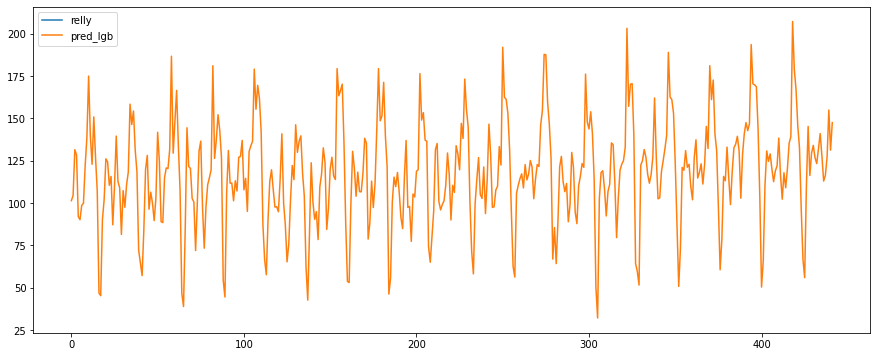

In [62]:
pred_plot.plot(figsize=(15, 6))
plt.show()

## Вывод

Проведя исследования и обработав даные, я сгрупировал количество заказов по часу.
Проверил что данные монотонные. Сделал их стационарным
При выборе модели лучшей оказалась LightGBT, которая на тестовой выборке выдала показатель 'RMSE - 47.5', что не противоречит условию задания. 
Что бы добиться улучшения показателя пришлось увеличить показатель 'max_lag' и 'rolling_mean_size' до 24, а так же при проверке тестовой выборки, более детально подобрать гиперпараметр.